<a href="https://colab.research.google.com/github/bassoline/DeepLearning/blob/main/LeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
%matplotlib inline 
import matplotlib.pyplot as plt 
import os 
import time 
from dataclasses import dataclass 
import numpy as np 
import torch 
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F
from torchvision import datasets, transforms

In [24]:
class LeNet5(nn.Module):

  def __init__(self):
    super().__init__()

    # convolution layers
    self._body = nn.Sequential(
        # input size = (32, 32), output size = (28, 28)
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2), 
        # second conv layer
        # input size (14, 14), output size = (10, 10)
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2) 
        # output is (5, 5)
    )

    # fully connected layers 
    self._head = nn.Sequential(
        # in features = total # of weights in last conv layer
        nn.Linear(in_features=16*5*5, out_features=120), 
        nn.ReLU(inplace=True),
        # second fully connected layer
        nn.Linear(in_features=120, out_features=84),
        nn.ReLU(inplace=True),
        # last fully connected layer
        nn.Linear(in_features=84, out_features=10)
    )

  def forward(self, x): 
    # apply feature extractor (conv layers)
    x = self._body(x)
    # flatten output of conv layer (dim should be batch_size * # of weights in 
    # last conv layer)
    x = x.view(x.size()[0], -1) 
    # apply classifier 
    x = self._head(x)
    return x 


In [25]:
class LeNet5BN(nn.Module):

  def __init__(self):
    super().__init__()

    # convolution layers
    self._body = nn.Sequential(
        # input size = (32, 32), output size = (28, 28)
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
        nn.BatchNorm2d(6),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2), 
        # second conv layer
        # input size (14, 14), output size = (10, 10)
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.BatchNorm2d(16),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2) 
        # output is (5, 5)
    )

    # fully connected layers 
    self._head = nn.Sequential(
        # in features = total # of weights in last conv layer
        nn.Linear(in_features=16*5*5, out_features=120), 
        nn.ReLU(inplace=True),
        # second fully connected layer
        nn.Linear(in_features=120, out_features=84),
        nn.ReLU(inplace=True),
        # last fully connected layer
        nn.Linear(in_features=84, out_features=10)
    )

  def forward(self, x): 
    # apply feature extractor (conv layers)
    x = self._body(x)
    # flatten output of conv layer (dim should be batch_size * # of weights in 
    # last conv layer)
    x = x.view(x.size()[0], -1) 
    # apply classifier 
    x = self._head(x)
    return x 

In [26]:
# initalize and display network 
lenet5_model = LeNet5()
print(lenet5_model)

# display batch norm network 
letnet5BN_model = LeNet5BN()
print(letnet5BN_model)

LeNet5(
  (_body): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (_head): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)
LeNet5BN(
  (_body): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): B

In [27]:
# get fashion mnist data 
def get_data(batch_size, data_root='data', num_workers=1):
  #calculate mean and std of data 
  # train_transform = transforms.Compose([transforms.ToTensor()])
  # train_set = datasets.FashionMNIST(root=data_root, train=True, download=True, transform=train_transform)
  # mean = train_set.data.float().mean()/255
  # std = train_set.data.float().std()
  # transform the data first, resize and normalize
  data_transform = transforms.Compose([
                                             transforms.Resize((32, 32)),
                                             # rescales to value between 0-1
                                             transforms.ToTensor(), 
                                             # first number is the mean and the second # is the variance (pre calculated)
                                             transforms.Normalize((0.2860, ), (0.3530, ))                                        
  ])

  # create the loaders
  train_loader = torch.utils.data.DataLoader(
      datasets.FashionMNIST(root=data_root, train=True, download=True, transform=data_transform), 
      batch_size = batch_size, 
      shuffle=True, 
      num_workers = num_workers
  )

  test_loader = torch.utils.data.DataLoader(
      datasets.FashionMNIST(root=data_root, train=False, download=True, transform=data_transform),
      batch_size=batch_size, 
      shuffle=False, 
      num_workers=num_workers
  )

  return train_loader, test_loader

In [28]:
# common settings for reproducibility 
@dataclass
class SystemConfiguration:
  seed: int = 42 # for rand nums 
  cudnn_benchmark_enabled: bool = True # for performance
  cudnn_deterministic: bool = True # reproducibility

In [29]:
@dataclass
class TrainingConfiguration:
  batch_size: int = 32 # amount of data passed through each iteration 
  epochs_count: int = 20 # of times all data will be passed through
  learning_rate: float = 0.01 # how fast we update the weights based on the gradients
  log_interval: int = 100 # how many batches between logging status
  test_interval: int = 1 # how many epoches to wait before another evaluation test 
  data_root: str = "data" # folder to save MNIST data at (data/mnist-data)
  num_workers: int = 10 # of concurrent processes used to prepare data
  device: str = 'cuda' # device used for training 

In [30]:
# checks for GPU availability and sets up the system for you 
def setup_system(system_config: SystemConfiguration) -> None: 
  torch.manual_seed(system_config.seed)
  if torch.cuda.is_available():
    torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
    torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

In [31]:
# training 
def train(
    train_config: TrainingConfiguration, 
    model: nn.Module, 
    optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, 
    epoch_idx: int
) -> None: 
  # set model to train mode
  model.train() 
  # for storing loss and accuracy 
  batch_loss = np.array([])
  batch_acc = np.array([])

  for batch_idx, (data, target) in enumerate(train_loader):
    l = len(data) 
    # clone the target 
    index_target = target.clone()
    # send data and target to device (for GPU) doesn't hurt if there is not GPU
    data = data.to(train_config.device)
    target = target.to(train_config.device)
    # set gradient to zero 
    optimizer.zero_grad()
    # forward pass 
    output = model(data)
    # cross entropy loss 
    loss = F.cross_entropy(output, target)
    # find gradients 
    loss.backward()
    # update parameters using gradients 
    optimizer.step()
    # keep track of loss 
    batch_loss = np.append(batch_loss, [loss.item()])
    # get probability and index of max probability 
    prob = F.softmax(output, dim=1)
    pred = prob.data.max(dim=1)[1]
    # get the correct prediction 
    correct = pred.cpu().eq(index_target).sum()
    # total accuracy for batch
    acc = float(correct) / float(l)
    batch_acc = np.append(batch_acc, [acc])
    # log training progress 
    if batch_idx % train_config.log_interval == 0 and batch_idx > 0: 
      print('Train Epoch: {} [{} / {}] Loss: {:.6f} Acc: {:.4f}'.format(
          epoch_idx, batch_idx * l, len(train_loader.dataset), loss.item(), acc
      ))
  epoch_loss = batch_loss.mean()
  epoch_acc = batch_acc.mean()
  return epoch_loss, epoch_acc

In [32]:
# validation 
def validation(
    train_config: TrainingConfiguration, 
    model: nn.Module, 
    test_loader: torch.utils.data.DataLoader
) -> float: 
  # set to eval mode
  model.eval()
  test_loss = 0 
  count_correct_predictions = 0 
  for data, target in test_loader: 
    index_target = target.clone()
    # move data over to GPU 
    data = data.to(train_config.device)
    target = target.to(train_config.device)
    # forward pass 
    output = model(data)
    # add loss for each mini-batch 
    test_loss += F.cross_entropy(output, target).item()
    # get probablity 
    prob = F.softmax(output, dim=1)
    # get index of prediction 
    pred = prob.data.max(dim = 1)[1]
    # add correct prediction count 
    count_correct_predictions += pred.cpu().eq(index_target).sum()
  
  # average over mini batch 
  test_loss = test_loss / len(test_loader) 
  accuracy = 1.00 * count_correct_predictions / len(test_loader.dataset)

  print(
      ('\nTest set: Average Loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n').format(
      test_loss, count_correct_predictions, len(test_loader.dataset), accuracy
      )
  )
  
  return test_loss, accuracy

In [33]:
def main(model, system_configuration=SystemConfiguration(), training_configuration=TrainingConfiguration()):
  print('using model ', model)
  # set up configurations
  setup_system(system_configuration)

  # check if GPU is available, if it's not set CPU settings
  if not torch.cuda.is_available():
    print('using CPU')
    training_configuration = TrainingConfiguration(
        device = "cpu",
        batch_size = "16",
        num_workers = 2,
        epoch_num = 5
    )
  
  # get data loaders 
  train_loader, test_loader = get_data(
      batch_size = training_configuration.batch_size, 
      data_root = training_configuration.data_root,
      num_workers = training_configuration.num_workers
  )

  # send model to device 
  model.to(training_configuration.device)
  # optimizer
  optimizer = optim.SGD(
      model.parameters(), 
      lr = training_configuration.learning_rate
  )

  # set starting loss to inf 
  best_loss = torch.tensor(np.inf)
  
  # initalize progress trackers 
  epoch_train_loss = np.array([])
  epoch_test_loss = np.array([])
  epoch_training_acc = np.array([])
  epoch_test_acc = np.array([])

  # initalize time measurement 
  t_begin = time.time()

  for epoch in range(training_configuration.epochs_count): 
    # get and store results of loss and accuracy from training 
    train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)
    epoch_train_loss = np.append(epoch_train_loss, [train_loss])
    epoch_training_acc = np.append(epoch_training_acc, [train_acc])
    # get time 
    elapsed_time = time.time() - t_begin 
    speed_epoch = elapsed_time / (epoch + 1)
    speed_batch = speed_epoch / len(train_loader)
    eta = speed_epoch * training_configuration.epochs_count - elapsed_time

    print("Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
        elapsed_time, speed_epoch, speed_batch, eta
    ))

    if epoch % training_configuration.test_interval == 0: 
      current_loss, current_accuracy = validation(training_configuration, model, test_loader)
      epoch_test_loss = np.append(epoch_test_loss, [current_loss])
      epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
      if current_loss < best_loss: 
        best_loss = current_loss

  print("Total time: {:.2f}, Best Loss: {:.3f}".format(
      time.time() - t_begin, best_loss)
  )
  return model, epoch_train_loss, epoch_training_acc, epoch_test_loss, epoch_test_acc

In [34]:
# run main for letnet5 w/o batch norm
model_, epoch_train_loss_, epoch_train_acc_, epoch_test_loss_, epoch_test_acc_ = main(lenet5_model)

using model  LeNet5(
  (_body): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (_head): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)
Train Epoch: 0 [3200 / 60000] Loss: 2.272800 Acc: 0.0625
Train Epoch: 0 [6400 / 60000] Loss: 2.085395 Acc: 0.3438
Train Epoch: 0 [9600 / 60000] Loss: 1.097376 Acc: 0.5312
Train Epoch: 0 [12800 / 60000] Loss: 0.979197 Acc: 0.6562
Train Epoch: 0 [16000 / 60000] Loss: 1.113133 Acc: 0.5625
Train Epoch: 0 [19200 / 60000] Loss: 0.728374 Acc: 0.6250


In [35]:
# run w batch norm 
modelBN, epoch_train_loss_bn, epoch_train_acc_bn, epoch_test_loss_bn, epoch_test_acc_bn = main(letnet5BN_model)

using model  LeNet5BN(
  (_body): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (_head): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)
Train Epoch: 0 [3200 / 60000] Loss: 2.020724 Acc: 0.4062
Train Epoch: 0 [6400 / 60000] Loss: 1.402881 Acc: 0.5625
Train Epoch: 0 [9600 / 60000] Loss: 0.842430 Acc: 0.

In [36]:
 # plot loss / accuracy
def plot(train, test, train_legend, test_legend, x_axis, y_axis, title):
  plt.rcParams["figure.figsize"] = (10,6)
  x = range(len(train))

  plt.figure
  plt.plot(x, train, color='r', label=train_legend)
  plt.plot(x, test, color='b', label=test_legend)

  # quick and dirty addition of letnet5BN plot
  x2 = range(len(epoch_train_loss_bn))
  plt.plot(x2, epoch_train_loss_bn, 'r--', label="train loss with BN")
  plt.plot(x2, epoch_test_loss_bn, 'b--',label="validation loss with BN")

  plt.xlabel(x_axis)
  plt.ylabel(y_axis)
  plt.legend(loc='upper right')
  plt.title(title)
  plt.show()

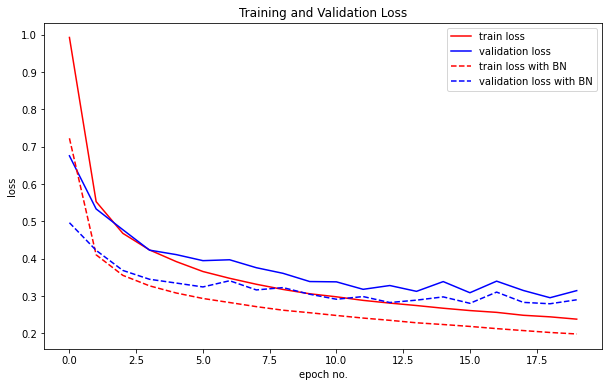

In [38]:
plot(epoch_train_loss_, epoch_test_loss_, "train loss", "validation loss", 'epoch no.', 'loss', 'Training and Validation Loss')

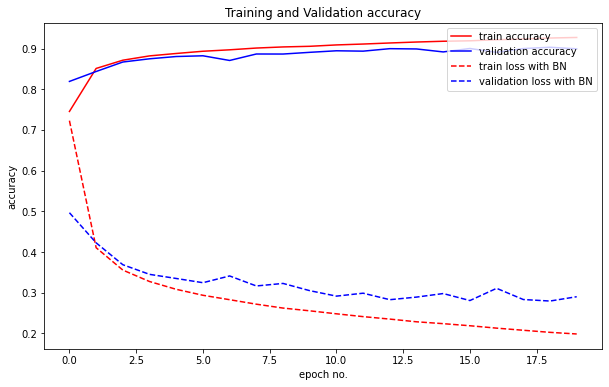

In [40]:
# plot accuracy
plot(epoch_train_acc_bn, epoch_test_acc_bn, "train accuracy", "validation accuracy", 'epoch no.', 'accuracy', 'Training and Validation accuracy')

In [87]:
# saving the model 
models = 'models'
if not os.path.exists(models):
  os.makedirs(models)

model_file_name = 'lenet5_mnist.pt'
model_path = os.path.join(models, model_file_name)
model.to('cpu')
# state dictionary contains all of the model parameters (weights and all)
# hyper parameters for training are in optimizer.state_dict() if you wanted to 
# continue learning later 
torch.save(model.state_dict(), model_path)

In [88]:
# loading the model 
lenet5_mnist = LeNet5()
lenet5_mnist.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [97]:
# model prediction
def prediction(model, train_config, batch_input): 
  model.to(train_config.device)
  # set model to eval state
  model.eval()
  # send input data to device
  data = batch_input.to(train_config.device)
  # forward pass
  output = model(data)
  # get prob using softmax 
  prob = F.softmax(output, dim=1)
  # get max probablilty
  pred_prob = prob.data.max(dim=1)[0]
  # get the index of max prob 
  pred_index = prob.data.max(dim=1)[1]

  return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

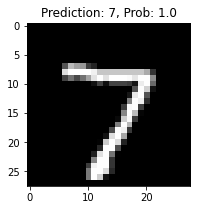

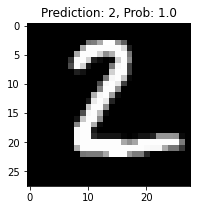

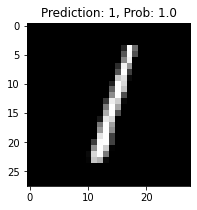

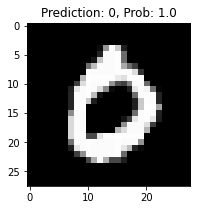

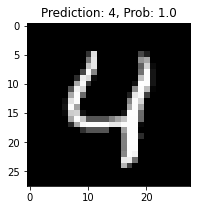

In [98]:
# perform inference on sample images 
batch_size = 5
device = "cuda" if torch.cuda.is_available() else "cpu"
train_config = TrainingConfiguration(device=device) 

# load some test data without any tranformations
test = torch.utils.data.DataLoader(
    datasets.MNIST(root=train_config.data_root, train=False, download=True, 
                   transform = transforms.functional.to_tensor),
                   batch_size = batch_size, 
                   shuffle = False, 
                   num_workers=1
)

# load data tranformed and ready to go through the NN 
image_transforms = transforms.Compose([
                                       transforms.Resize((32, 32)), 
                                       transforms.ToTensor(), 
                                       transforms.Normalize((0.1307,), (0.3081,))
])

test_trans = torch.utils.data.DataLoader(
    datasets.MNIST(root=train_config.data_root, train=False, download=True, transform=image_transforms),
    batch_size=batch_size, 
    shuffle= False, 
    num_workers = 1
)

# run through a single batch
for data, _ in test_trans: 
  pred, prob = prediction(lenet5_mnist, train_config, data)
  break

# display results
plt.rcParams["figure.figsize"] = (3, 3)
for images, _ in test: 
  for i, img in enumerate(images): 
    img = transforms.functional.to_pil_image(img)
    plt.imshow(img, cmap='gray')
    plt.gca().set_title('Prediction: {0}, Prob: {1:.2}'.format(pred[i], prob[i]))
    plt.show()
  break

